In [0]:
'''
This Notebook provides implementation how to build Neural network based model for Audio Classification. 

There are two ways to prepare a data (mfcc values of audios) for model building. 
A. Either download flicker dataset and iterate over it to get the MFCC values and use them for model building 
B. Or get these MFCC values calculated and stored into Numpy variables part of feature-extraction process and here load these Numpy array
 
'''

In [0]:
!pip install q keras==2.3.0
!pip install tensorflow_hub

In [0]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import random
from random import seed
from random import randint
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
import math
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 

import tensorflow as tf
import keras

from keras import layers
from keras import models
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K
from keras.utils import np_utils
from keras.utils import to_categorical

'''
Dropout, SGD, Adam

from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten, Dropout, Dense, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
'''

'\nDropout, SGD, Adam\n\nfrom tensorflow import keras\nfrom tensorflow.keras.models import Sequential \nfrom tensorflow.keras.layers import BatchNormalization, Activation, Flatten, Dropout, Dense, Conv2D, MaxPooling2D\nfrom keras.callbacks import ModelCheckpoint\nfrom tensorflow.keras.optimizers import SGD\nfrom tensorflow.keras.optimizers import Adam\n'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Extract MFCC
def extract_mfcc_scaled_features(audio, sample_rate):
    try:
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

#given a signal, noise (audio) and desired SNR, this gives the noise (scaled version of noise input) that gives the desired SNR
def get_noise_from_sound(signal,noise,SNR):
    RMS_s=np.sqrt(np.mean(signal**2))
    #required RMS of noise
    RMS_n=np.sqrt(RMS_s**2/(pow(10,SNR/20)))
    #current RMS of noise
    RMS_n_current=np.sqrt(np.mean(noise**2))

    noise=noise*(RMS_n/RMS_n_current)
    return noise

In [0]:
'''
Note: Run this steps only when you want to calculate MFCC values from start. If you have exisitng mfcc values calcualted then move to next cell.

'''

!wget https://groups.csail.mit.edu/sls/downloads/flickraudio/downloads/flickr_audio.tar.gz
!gunzip -d flickr_audio.tar.gz
!tar -xvf flickr_audio.tar

This corpus includes 40,000 spoken captions of 8,000 natural images. It was collected in 2015 to investigate multimodal learning schemes for unsupervised speech pattern discovery.

In [0]:
'''
Note: Run this steps only when you want to calculate MFCC values from start. If you have exisitng mfcc values calcualted then move to next cell.

'''

#extarct MFCC values of original flickr audio
features= []
features_noise= []
%cd /content/noise
Noise_Files=os.listdir()

%cd /content/flickr_audio/wavs
Files=os.listdir()

for file in Files:
  audio, sample_rate = librosa.load(file) 
  mfcc = extract_mfcc_scaled_features(audio, sample_rate)
  class_label = "original"
  features.append([mfcc, class_label])
  
  sound, sr_sound = librosa.load(('/content/noise/'+ str(random.choice(Noise_Files))), res_type='kaiser_fast') 
  ns_signal = get_noise_from_sound(sound,audio,SNR = 16)
  mixed_noise_signal = audio + ns_signal
  mfcc = extract_mfcc_scaled_features(mixed_noise_signal, sample_rate)
  class_label = "noise"
  features_noise.append([mfcc, class_label])


featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
featuresdf_noise = pd.DataFrame(features_noise, columns=['feature','class_label'])

frames= [featuresdf, featuresdf_noise]
audio_data_df = pd.concat(frames)
audio_data_df = shuffle(audio_data_df)

In [0]:
'''
Note: Either you need to have exisitng mfcc values calcualted in form of Numpy array which you can use it here. Or else you need 
to run previous steps.

'''

Y_NP_ARRAY = np.load('/content/drive/My Drive/Audio_Quality_Analysis/data/result_np_array_Y.npy',allow_pickle=True)
X_NP_ARRAY = np.load('/content/drive/My Drive/Audio_Quality_Analysis/data/result_np_array_X.npy',allow_pickle=True)
audio_data_df = pd.DataFrame({'label': Y_NP_ARRAY, 'features': X_NP_ARRAY}, columns=['label', 'features'])
print(audio_data_df.head())
audio_data_df['label'][audio_data_df.label != "original"] = "noise"

,label,features
0,Air_FX_01.wav,"[-296.09265, 77.71805, 10.179534, 17.643902, 7..."
1,Gate_Filtered_01(130BPM).wav,"[-402.7919, 150.67755, 22.646318, 16.35733, -2..."
2,original,"[-72.46282, -7.0240526, -84.88628, 24.051159, ..."
3,Gate_Filtered_01(130BPM).wav,"[-289.94855, 60.071983, -29.34348, -2.4184382,..."
4,original,"[-120.78535, 128.26495, -48.094044, 30.60069, ..."


In [0]:
X = np.array(audio_data_df.features.tolist())
y = np.array(audio_data_df.label.tolist())

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)
len(x_train[0])

40

In [0]:
# Construct model

num_labels = yy.shape[1]
filter_size = 2
 
model = models.Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(Dense(num_labels))
model.add(layers.Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_8 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                

In [0]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Pre-training accuracy: 49.4704%


In [0]:
from datetime import datetime 

num_epochs = 100
num_batch_size = 32
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 13971 samples, validate on 3493 samples
Epoch 1/100
13971/13971 [==============================] - 1s 96us/step - loss: 2.4140 - accuracy: 0.5324 - val_loss: 0.6784 - val_accuracy: 0.5709
Epoch 2/100
13971/13971 [==============================] - 1s 84us/step - loss: 0.7019 - accuracy: 0.5734 - val_loss: 0.6816 - val_accuracy: 0.5451
Epoch 3/100
13971/13971 [==============================] - 1s 83us/step - loss: 0.6635 - accuracy: 0.6057 - val_loss: 0.6584 - val_accuracy: 0.6118
Epoch 4/100
13971/13971 [==============================] - 1s 83us/step - loss: 0.6371 - accuracy: 0.6391 - val_loss: 0.6103 - val_accuracy: 0.6931
Epoch 5/100
13971/13971 [==============================] - 1s 85us/step - loss: 0.6147 - accuracy: 0.6599 - val_loss: 0.6054 - val_accuracy: 0.6628
Epoch 6/100
13971/13971 [==============================] - 1s 84us/step - loss: 0.5939 - accuracy: 0.6774 - val_loss: 0.5805 - val_accuracy: 0.6940
Epoch 7/100
13971/13971 [==============================] - 1s 8

In [0]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.5982391834259033
Testing Accuracy:  0.5785857439041138


In [0]:
model.save("/content/drive/My Drive/Audio_Quality_Analysis/model/AudioQuality_V1_04102020.h5")
model.save_weights("/content/drive/My Drive/Audio_Quality_Analysis/model/AudioQualityWeights_V1_04102020.h5")

In [0]:
audio_data, sample_rate = librosa.load('/content/Noise/Air_FX_01.wav', res_type='kaiser_fast') 
mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
mfccsscaled = np.mean(mfccs.T,axis=0)

prediction_feature = np.array([mfccsscaled])
predicted_vector = model.predict_classes(prediction_feature)
predicted_class = le.inverse_transform(predicted_vector) 
predicted_proba_vector = model.predict_proba(prediction_feature) 

print('Predicting class:', predicted_class, '\n')
predicted_proba_vector

Predicting class: ['noise'] 



array([[0.53085226, 0.46914777]], dtype=float32)

In [0]:
audio_data, sample_rate = librosa.load('/content/00b01445_nohash_0.wav', res_type='kaiser_fast') 
mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
mfccsscaled = np.mean(mfccs.T,axis=0)

prediction_feature = np.array([mfccsscaled])
predicted_vector = model.predict_classes(prediction_feature)
predicted_class = le.inverse_transform(predicted_vector) 
predicted_proba_vector = model.predict_proba(prediction_feature) 

print('Predicting class:', predicted_class, '\n')
predicted_proba_vector

Predicting class: ['original'] 



array([[0., 1.]], dtype=float32)

In [0]:
audio_data, sample_rate = librosa.load('/content/file_example_WAV_1MG.wav', res_type='kaiser_fast') 
mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
mfccsscaled = np.mean(mfccs.T,axis=0)

prediction_feature = np.array([mfccsscaled])
predicted_vector = model.predict_classes(prediction_feature)
predicted_class = le.inverse_transform(predicted_vector) 
predicted_proba_vector = model.predict_proba(prediction_feature) 

print('Predicting class:', predicted_class, '\n')
predicted_proba_vector

Predicting class: ['noise'] 



array([[1., 0.]], dtype=float32)

In [0]:
!wget https://www.ee.columbia.edu/~dpwe/sounds/noise/airport.wav


--2020-04-09 11:28:14--  https://www.ee.columbia.edu/~dpwe/sounds/noise/airport.wav
Resolving www.ee.columbia.edu (www.ee.columbia.edu)... 128.59.64.28
Connecting to www.ee.columbia.edu (www.ee.columbia.edu)|128.59.64.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160044 (156K) [audio/x-wav]
Saving to: ‘airport.wav’

airport.wav         100%[===================>] 156.29K   295KB/s    in 0.5s    

2020-04-09 11:28:15 (295 KB/s) - ‘airport.wav’ saved [160044/160044]



In [0]:
!wget https://file-examples.com/wp-content/uploads/2017/11/file_example_WAV_1MG.wav

--2020-04-09 11:31:42--  https://file-examples.com/wp-content/uploads/2017/11/file_example_WAV_1MG.wav
Resolving file-examples.com (file-examples.com)... 185.135.88.81
Connecting to file-examples.com (file-examples.com)|185.135.88.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1073218 (1.0M) [audio/x-wav]
Saving to: ‘file_example_WAV_1MG.wav’

file_example_WAV_1M 100%[===================>]   1.02M   648KB/s    in 1.6s    

2020-04-09 11:31:45 (648 KB/s) - ‘file_example_WAV_1MG.wav’ saved [1073218/1073218]



In [0]:
%cd /content
!ls


/content
00b01445_nohash_0.wav  file_example_WAV_1MG.wav  flickr_audio.tar  sample_data
airport.wav	       flickr_audio		 Noise


In [0]:
'flickr_audio/wavs/143688205_630813a466_2.wav'

In [0]:
audio_data, sample_rate = librosa.load('/content/221[kb]are_you_done_mixing_yet.aif.mp3', res_type='kaiser_fast') 
mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
mfccsscaled = np.mean(mfccs.T,axis=0)

prediction_feature = np.array([mfccsscaled])
predicted_vector = model.predict_classes(prediction_feature)
predicted_class = le.inverse_transform(predicted_vector) 
predicted_proba_vector = model.predict_proba(prediction_feature) 

print('Predicting class:', predicted_class, '\n')
predicted_proba_vector

Predicting class: ['noise'] 



array([[1., 0.]], dtype=float32)

In [0]:
!wget https://sampleswap.org/samples-ghost/VOCALS%20and%20SPOKEN%20WORD/Children/221[kb]are_you_done_mixing_yet.aif.mp3

--2020-04-09 11:40:41--  https://sampleswap.org/samples-ghost/VOCALS%20and%20SPOKEN%20WORD/Children/221[kb]are_you_done_mixing_yet.aif.mp3
Resolving sampleswap.org (sampleswap.org)... 69.167.149.24
Connecting to sampleswap.org (sampleswap.org)|69.167.149.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13810 (13K) [audio/mpeg]
Saving to: ‘221[kb]are_you_done_mixing_yet.aif.mp3’

221[kb]are_you_done 100%[===================>]  13.49K  --.-KB/s    in 0s      

2020-04-09 11:40:42 (27.4 MB/s) - ‘221[kb]are_you_done_mixing_yet.aif.mp3’ saved [13810/13810]



In [0]:
!wget https://sampleswap.org/samples-ghost/VOCALS%20and%20SPOKEN%20WORD/Children/2088[kb]arials-melody.aif.mp3

--2020-04-09 11:42:29--  https://sampleswap.org/samples-ghost/VOCALS%20and%20SPOKEN%20WORD/Children/2088[kb]arials-melody.aif.mp3
Resolving sampleswap.org (sampleswap.org)... 69.167.149.24
Connecting to sampleswap.org (sampleswap.org)|69.167.149.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64845 (63K) [audio/mpeg]
Saving to: ‘2088[kb]arials-melody.aif.mp3’

2088[kb]arials-melo 100%[===================>]  63.33K   186KB/s    in 0.3s    

2020-04-09 11:42:30 (186 KB/s) - ‘2088[kb]arials-melody.aif.mp3’ saved [64845/64845]



In [0]:
audio_data, sample_rate = librosa.load('/content/2088[kb]arials-melody.aif.mp3', res_type='kaiser_fast') 
mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
mfccsscaled = np.mean(mfccs.T,axis=0)

prediction_feature = np.array([mfccsscaled])
predicted_vector = model.predict_classes(prediction_feature)
predicted_class = le.inverse_transform(predicted_vector) 
predicted_proba_vector = model.predict_proba(prediction_feature) 

print('Predicting class:', predicted_class, '\n')
predicted_proba_vector

Predicting class: ['noise'] 



array([[1., 0.]], dtype=float32)

In [0]:
audio_data, sample_rate = librosa.load('/content/Welcome.wav', res_type='kaiser_fast') 
mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
mfccsscaled = np.mean(mfccs.T,axis=0)

prediction_feature = np.array([mfccsscaled])
predicted_vector = model.predict_classes(prediction_feature)
predicted_class = le.inverse_transform(predicted_vector) 
predicted_proba_vector = model.predict_proba(prediction_feature) 

print('Predicting class:', predicted_class, '\n')
predicted_proba_vector

Predicting class: ['original'] 



array([[0., 1.]], dtype=float32)

In [0]:
audio_data, sample_rate = librosa.load('/content/bigtips_f16r1_16.wav', res_type='kaiser_fast') 
mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
mfccsscaled = np.mean(mfccs.T,axis=0)

prediction_feature = np.array([mfccsscaled])
predicted_vector = model.predict_classes(prediction_feature)
predicted_class = le.inverse_transform(predicted_vector) 
predicted_proba_vector = model.predict_proba(prediction_feature) 

print('Predicting class:', predicted_class, '\n')
predicted_proba_vector

Predicting class: ['original'] 



array([[0., 1.]], dtype=float32)

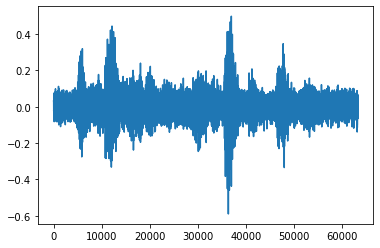

In [0]:
plt.plot(audio_data)